In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


2025-04-23 08:25:30.252967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745396730.445110      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745396730.498249      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set the base directory for the dataset
base_dir = "/kaggle/input/rice-image-dataset"

Step 2: Dataset Exploration and Preparation
Let's explore the dataset structure and prepare it for training:

Available rice varieties: ['Karacadag', 'Basmati', 'Jasmine', 'Rice_Citation_Request.txt', 'Arborio', 'Ipsala']
Image counts per variety: {'Karacadag': 15000, 'Basmati': 15000, 'Jasmine': 15000, 'Arborio': 15000, 'Ipsala': 15000}
                                          image_path      label
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag


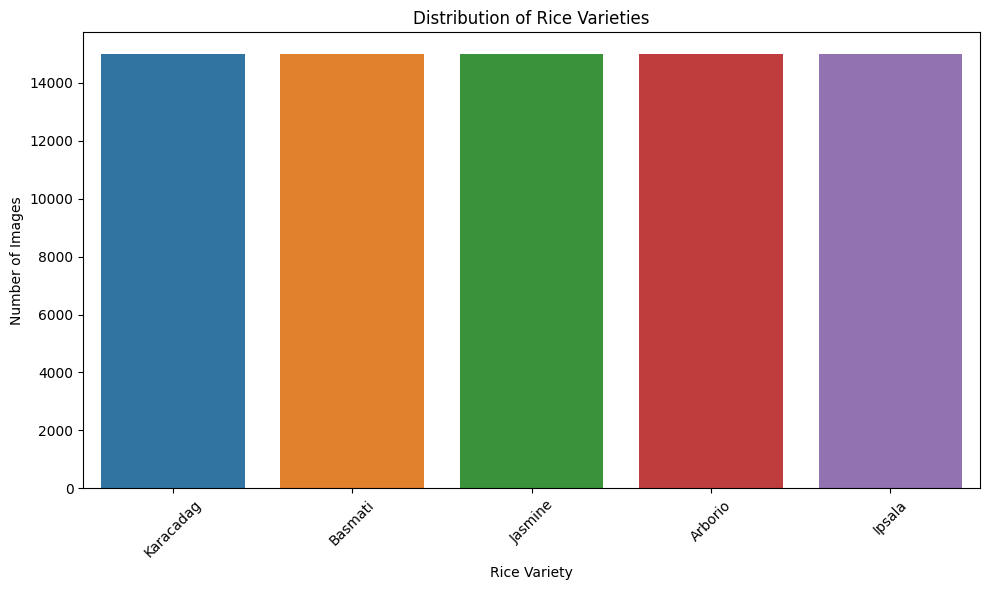

In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Fixed path: point directly to rice variety folders
base_dir = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

# List rice varieties (folder names)
rice_varieties = os.listdir(base_dir)
print(f"Available rice varieties: {rice_varieties}")

# Count images and prepare dataset
img_counts = {}
all_image_paths = []
all_labels = []

for variety in rice_varieties:
    variety_dir = os.path.join(base_dir, variety)
    if os.path.isdir(variety_dir):
        images = [f for f in os.listdir(variety_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        img_counts[variety] = len(images)
        
        for img in images:
            img_path = os.path.join(variety_dir, img)
            all_image_paths.append(img_path)
            all_labels.append(variety)

print(f"Image counts per variety: {img_counts}")

# Build dataframe
df = pd.DataFrame({
    'image_path': all_image_paths,
    'label': all_labels
})

print(df.head())

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Rice Varieties')
plt.xlabel('Rice Variety')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Step 3: Train-Test Split (80/20)

In [5]:
#Split the data into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

# Check class distribution in train and test sets
print("\nTraining set class distribution:")
print(train_df['label'].value_counts())
print("\nTesting set class distribution:")
print(test_df['label'].value_counts())

Training set size: 60000
Testing set size: 15000

Training set class distribution:
label
Basmati      12000
Ipsala       12000
Karacadag    12000
Arborio      12000
Jasmine      12000
Name: count, dtype: int64

Testing set class distribution:
label
Arborio      3000
Ipsala       3000
Karacadag    3000
Jasmine      3000
Basmati      3000
Name: count, dtype: int64


Step 4: Data Preprocessing and Augmentation
Let's set up data generators with augmentation for training

In [6]:
# Define image dimensions and batch size
img_height, img_width = 224, 224  # Standard input size for VGG16
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the class indices
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Number of classes
num_classes = len(class_indices)
print(f"Number of classes: {num_classes}")

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Class indices: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
Number of classes: 5


Step 5: Build the VGG16-based CNN Model
Now, let's create our CNN model using the pre-trained VGG16:

In [7]:
# Load the VGG16 model pre-trained on ImageNet without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

I0000 00:00:1745396889.010650      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,692,869 (105.64 MB)

 Trainable params: 12,978,181 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Step 6: Train the Model with Callbacks
Let's train the model with callbacks for early stopping and learning rate reduction:

In [8]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('rice_classifier_vgg16.keras', save_best_only=True, monitor='val_accuracy')
]

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=8,  # You can adjust this
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745396898.530628      74 service.cc:148] XLA service 0x7eef90006510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745396898.531353      74 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745396898.923463      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1875 ━━━━━━━━━━━━━━━━━━━━ 2:22 76ms/step - accuracy: 0.1641 - loss: 2.7187  

I0000 00:00:1745396907.828297      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 926s 486ms/step - accuracy: 0.7035 - loss: 0.8046 - val_accuracy: 0.9748 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/8


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._sa

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 729s 388ms/step - accuracy: 0.8511 - loss: 0.3804 - val_accuracy: 0.8515 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 723s 384ms/step - accuracy: 0.8629 - loss: 0.3670 - val_accuracy: 0.9263 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 725s 385ms/step - accuracy: 0.8872 - loss: 0.3121 - val_accuracy: 0.9372 - val_loss: 0.1984 - learning_rate: 0.0010
Epoch 8/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010


Step 7: Evaluate the Model and Visualize Results
Now, let's evaluate the model's performance

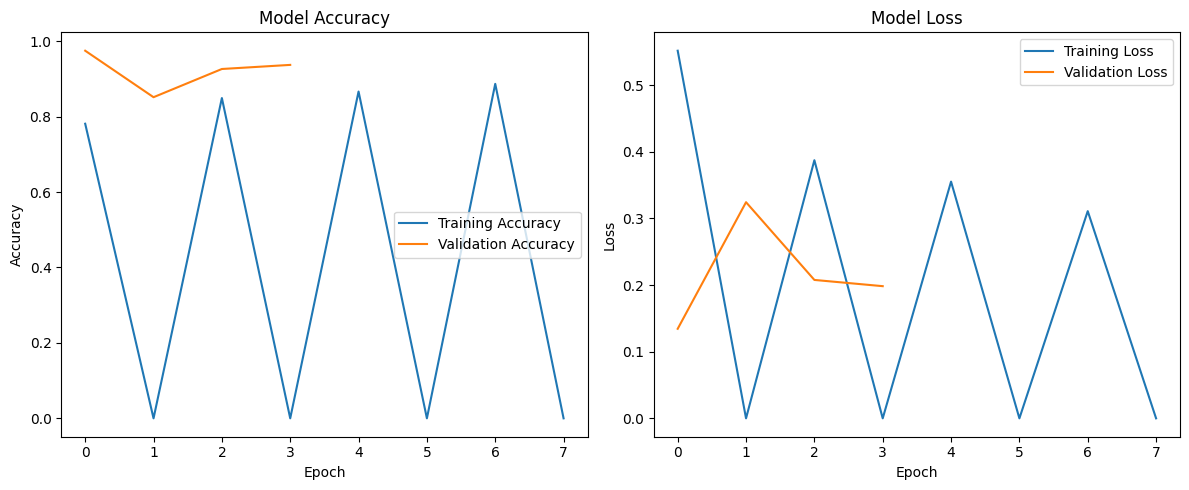

469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step
Test Accuracy: 0.9748

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.98      0.97      0.97      3000
     Basmati       0.99      0.95      0.97      3000
      Ipsala       0.99      1.00      1.00      3000
     Jasmine       0.95      0.97      0.96      3000
   Karacadag       0.97      0.99      0.98      3000

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



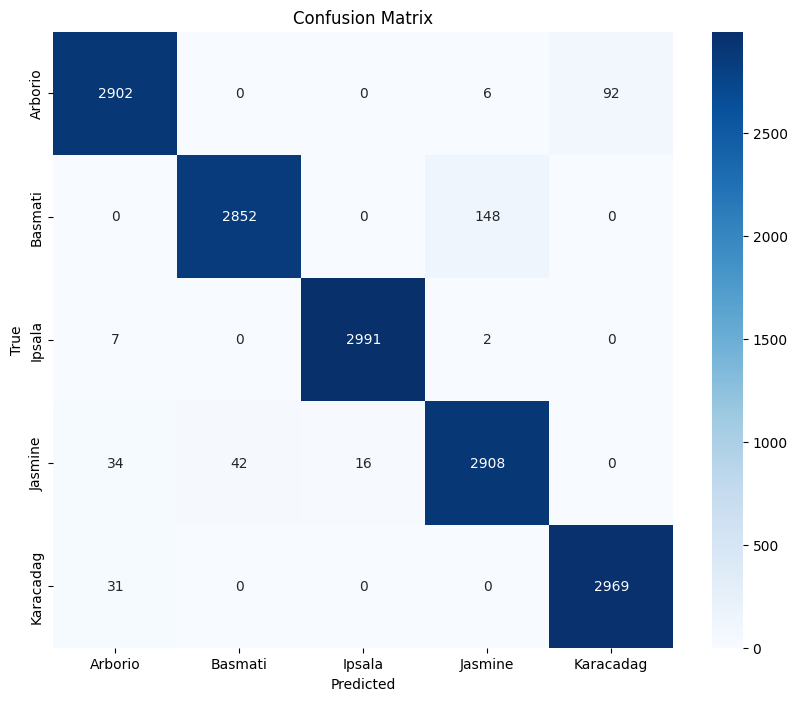

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Get predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Convert class indices back to labels
labels = {v: k for k, v in class_indices.items()}
y_pred_labels = [labels[i] for i in y_pred]
y_true_labels = [labels[i] for i in y_true]

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Step 8: Fine-tune the Model (Optional)
If you want to improve performance, you can fine-tune the last few layers of VGG16:

In [10]:
#Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Fewer epochs for fine-tuning
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Evaluate the fine-tuned model
test_generator.reset()
Y_pred = model.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(Y_pred, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print(f"Fine-tuned Test Accuracy: {accuracy:.4f}")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 739s 390ms/step - accuracy: 0.8909 - loss: 0.2784 - val_accuracy: 0.9919 - val_loss: 0.0322 - learning_rate: 1.0000e-05
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/10


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._sa

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 701s 373ms/step - accuracy: 0.9733 - loss: 0.0887 - val_accuracy: 0.9921 - val_loss: 0.0283 - learning_rate: 1.0000e-05
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 723s 384ms/step - accuracy: 0.9831 - loss: 0.0605 - val_accuracy: 0.9930 - val_loss: 0.0223 - learning_rate: 1.0000e-05
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 734s 390ms/step - accuracy: 0.9873 - loss: 0.0447 - val_accuracy: 0.9755 - val_loss: 0.0754 - learning_rate: 1.0000e-05
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 726s 386ms/step - accuracy: 0.9897 - loss: 0.0361 - val_accuracy: 0.9963 - val_loss: 0.0140 - learning_rate:

Step 10: Save the Model for Future Use
Finally, let's save the model for future use:

In [11]:
# Save the model
model.save('rice_classifier_final.h5')

# Save the class indices for future reference
import json
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("Model and class indices saved!")

Model and class indices saved!


In [19]:

# ✅ Install Gradio (run this cell only once)
!pip install gradio -q

# ✅ Imports
import gradio as gr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ✅ Image input size (update this if your model uses different dimensions)
img_height = 224
img_width = 224

# ✅ Define your actual class names here in the correct order
# Replace with your rice variety names in the same order your model was trained
labels = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "karacadag"
}

# ✅ Prediction function
def predict_rice_variety(image):
    # Preprocess image
    img = tf.image.resize(image, (img_height, img_width))
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = labels[predicted_class_idx]
    confidence = float(prediction[0][predicted_class_idx])

    # Format results
    result = {class_name: float(pred) for class_name, pred in zip(labels.values(), prediction[0])}

    return result

# ✅ Gradio UI
iface = gr.Interface(
    fn=predict_rice_variety,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=5),
    title="Rice Variety Classifier",
    description="Upload an image of rice grains to classify its variety"
)

# ✅ Launch interface (share=True is essential in Kaggle for public link)
iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://7ebe942ce4754dc3a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
